<a href="https://colab.research.google.com/github/paulo-batista/Learning.ai/blob/main/KerasCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Escrevendo por meio de linguagem de sinais com KerasCV

### Setup

In [ ]:
!pip install keras-cv keras-core -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 18.0 MB/s eta 0:00:00


### Utils

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import PIL
from IPython.display import Image
import cv2

import io
from base64 import b64decode, b64encode

In [ ]:
def preprocess_data(images, labels, num_classes):
    labels = tf.one_hot(labels, num_classes)
    return images, labels

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

  return img

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

### Criando dataset e treinando o modelo

In [ ]:
import keras_core as keras
import keras_cv
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

Using TensorFlow backend


In [ ]:
alfabeto_reduzido = ['nada', 'A', 'E', 'L', 'U', 'V']

In [ ]:
!mkdir training
for char in alfabeto_reduzido:
  !mkdir training/{char}

In [ ]:
from IPython.display import Image

for char in alfabeto_reduzido:
  print(char)
  for i in range(5):
    try:
      filename = take_photo(filename=f"training/{char}/{i}.jpg")
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

nada


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

A


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

E


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

L


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

U


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

V


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/training",
  seed=123,
  image_size=(200, 200),
  batch_size=3)

Found 30 files belonging to 6 classes.


In [ ]:
class_names = train_ds.class_names
len(class_names)

6

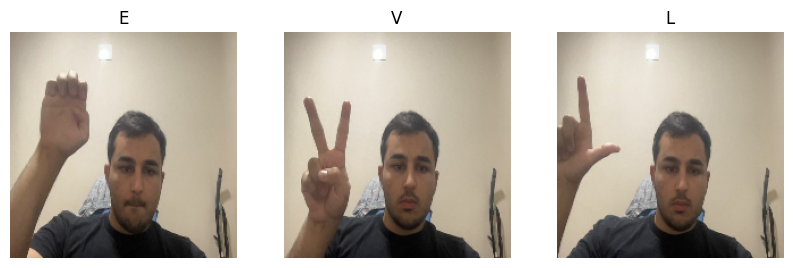

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_dataset = train_ds.map(
    lambda x, y: preprocess_data(x, y, len(class_names)),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

In [ ]:
# Create a model using a pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet"
)
backbone.trainable = False
model = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=len(class_names),
    activation="softmax",
)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "image_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 efficient_net_v2_backbone_1  (None, None, None, 1280)  5919312  
  (EfficientNetV2Backbone)                                       
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 predictions (Dense)         (None, 6)                 7686      
                                                                 
Total params: 5,926,998
Trainable params: 7,686
Non-trainable params: 5,919,312
_________________________________________________________________


In [ ]:
# # Train your model
model.fit(
    train_dataset,
    epochs=10,
    verbose=1,
)

Epoch 1/10
10/10 [==============================] - 9s 14ms/step - loss: 1.8006 - accuracy: 0.1667
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 1.6543 - accuracy: 0.3667
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 1.4865 - accuracy: 0.7000
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 1.3754 - accuracy: 0.8000
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 1.2632 - accuracy: 0.9000
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 1.1428 - accuracy: 0.9333
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 1.0653 - accuracy: 0.9000
Epoch 8/10
10/10 [==============================] - 0s 18ms/step - loss: 1.0122 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 17ms/step - loss: 0.9668 - accuracy: 0.9000
Epoch 10/10
10/10 [==============================] - 0s 18ms/step - loss: 0.8885 - accuracy: 0.9667


### Inferência em tempo real

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
result_bytes = ''
count = 0
sentence = ' '
while True:
    js_reply = video_frame(label_html, result_bytes)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    output = model.predict(np.array(PIL.Image.fromarray(frame).resize((200, 200)))[np.newaxis,:], verbose=0)
    class_result = np.zeros([480,640,4], dtype=np.uint8)
    char_result = class_names[np.argmax(output)]
    class_result = cv2.putText(class_result, "{} [{:.2f}]".format(char_result, output.max()),
                        (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    if char_result != sentence[-1] and char_result != "nada":
      sentence += char_result

    class_result = cv2.putText(class_result, "{}".format(sentence),
                        (300, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    class_result[:,:,3] = (class_result.max(axis = 2) > 0 ).astype(int) * 255
    iobuf = io.BytesIO()
    # format bbox into png for return
    PIL.Image.fromarray(class_result).save(iobuf, format='png')
    # format return string
    result_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))



<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored